In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os

# To plot pretty figures
#%matplotlib inline
# import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "LAB6"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "src_images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def get_path(fig_name, fig_extension="pdf"):
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    return path


In [2]:
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Superdense coding

In [3]:
def create_bell_pair():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    return qc

In [4]:
def encode_message(qc, qubit, msg):
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc

In [5]:
def decode_message(qc):
    qc.cx(0,1)
    qc.h(0)
    return qc

In [6]:
# Charlie creates the Bell Pair
qc = create_bell_pair()
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=(2, "q"), index=1>), clbits=())

In [7]:
#Alice encodes the message
message = "01"
qc = encode_message(qc,0, message)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "q"), index=0>, <Qubit register=(2, "q"), index=1>), clbits=())

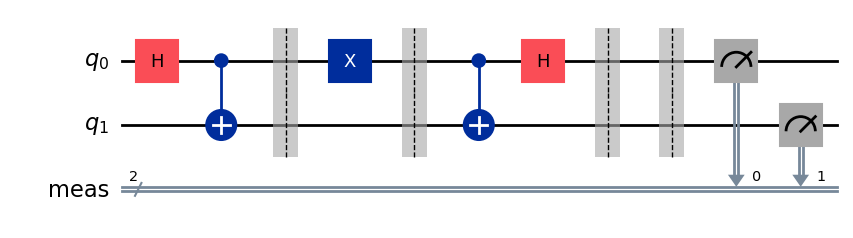

In [8]:
#Bob decodes
qc = decode_message(qc)
qc.barrier()
qc.measure_all()
qc.draw(output="mpl")

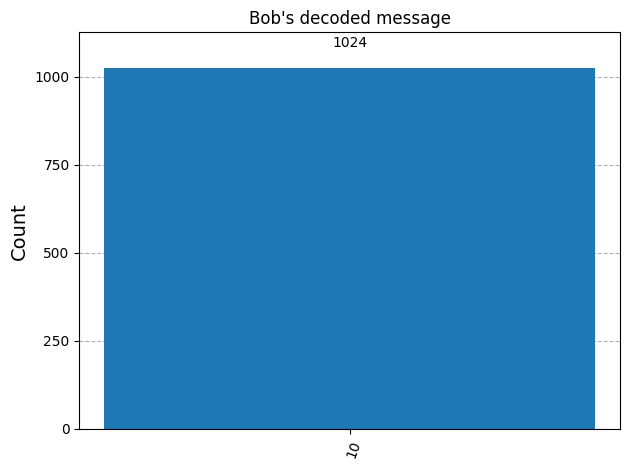

In [9]:
# Transpile for simulator
simulator = AerSimulator()
qc = transpile(qc, simulator)
results = simulator.run(qc).result()
counts = results.get_counts(qc)
plot_histogram(counts, title="Bob's decoded message")

# Quantum teleportation

In [10]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex,plot_bloch_multivector
from qiskit.quantum_info import random_statevector
from qiskit.result import marginal_counts

In [11]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [12]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)


In [13]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [14]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    with qc.if_test((crx, 1)):
        qc.x(qubit)
    with qc.if_test((crz,1)):
        qc.z(qubit)
    

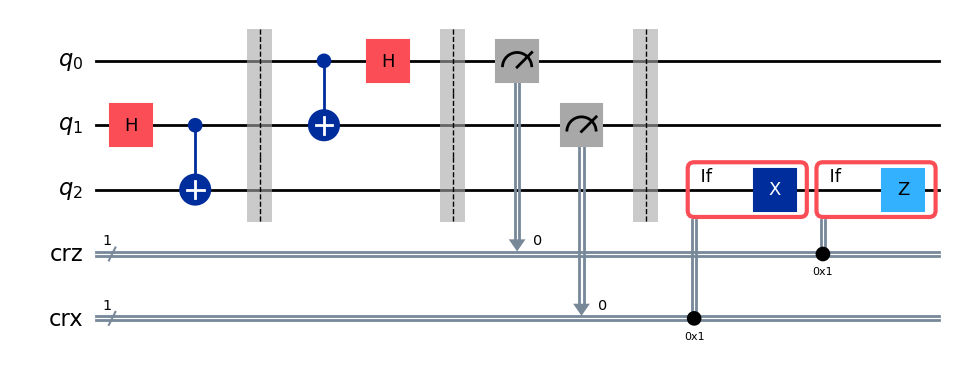

In [15]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)


## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)


## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw(output='mpl')

<IPython.core.display.Latex object>

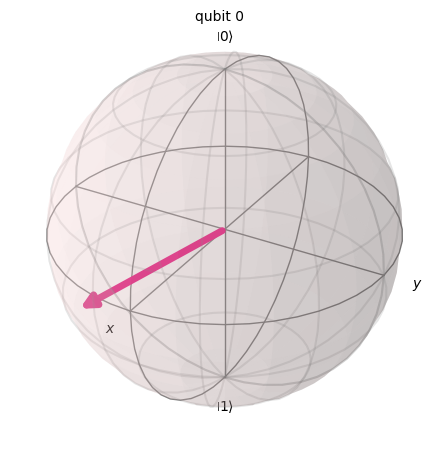

In [16]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [17]:
from qiskit.circuit.library import StatePreparation

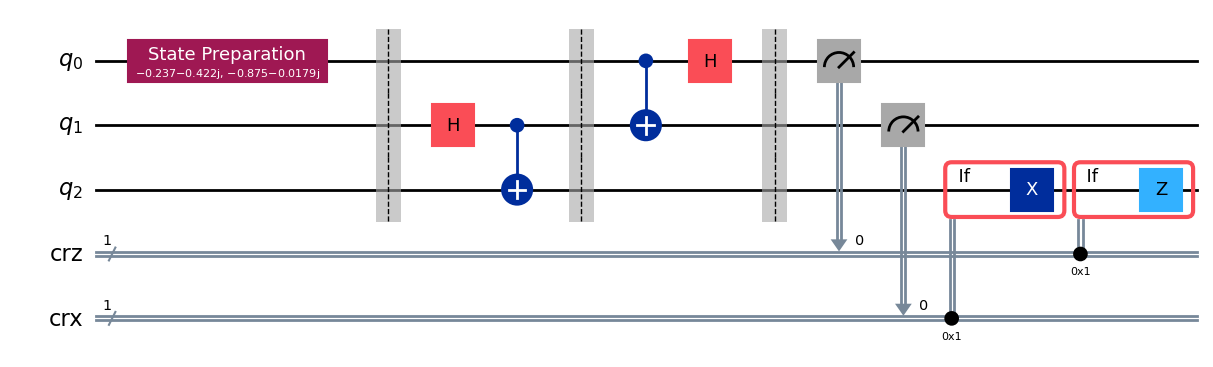

In [18]:
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(StatePreparation(psi), [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw(output="mpl")

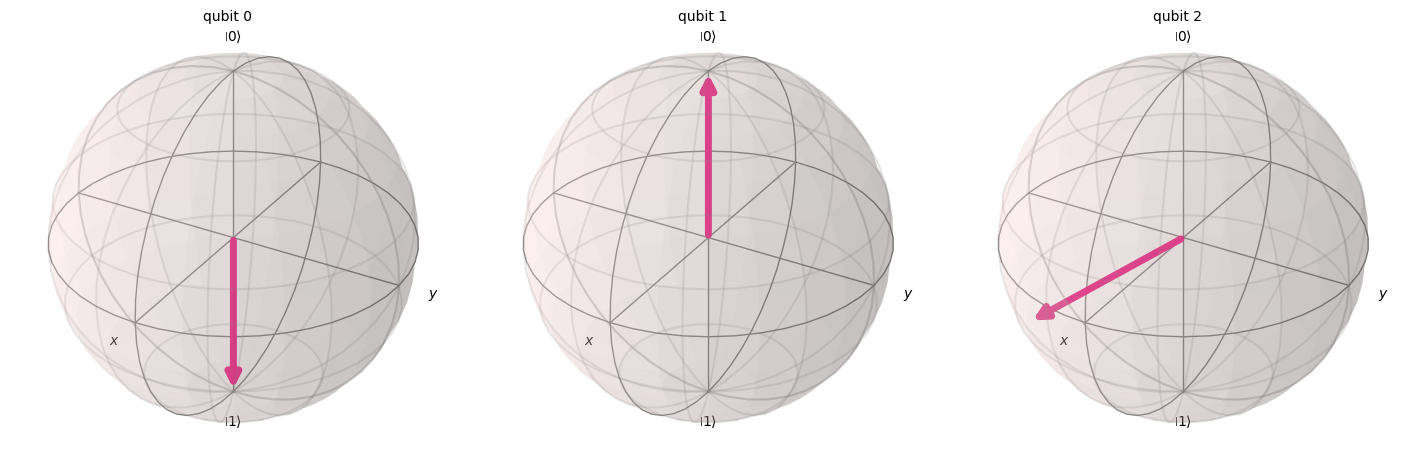

In [19]:
# Transpile for simulator
# simulator = AerSimulator()
# qc = transpile(qc, simulator)
# results = simulator.run(qc).result()
# counts = results.get_counts(qc)
# plot_histogram(counts, title="Bob's decoded message")

qc.save_statevector()
simulator = AerSimulator(method='statevector')
qc = transpile(qc, simulator)

# Run and get statevector
result = simulator.run(qc).result()
statevector = result.get_statevector(qc)
plot_bloch_multivector(statevector)





# The solution that can work on a quantum computer

In [20]:
init_gate = StatePreparation(psi)
init_gate.label = "init"
inverse_init_gate = init_gate.inverse()

In [21]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

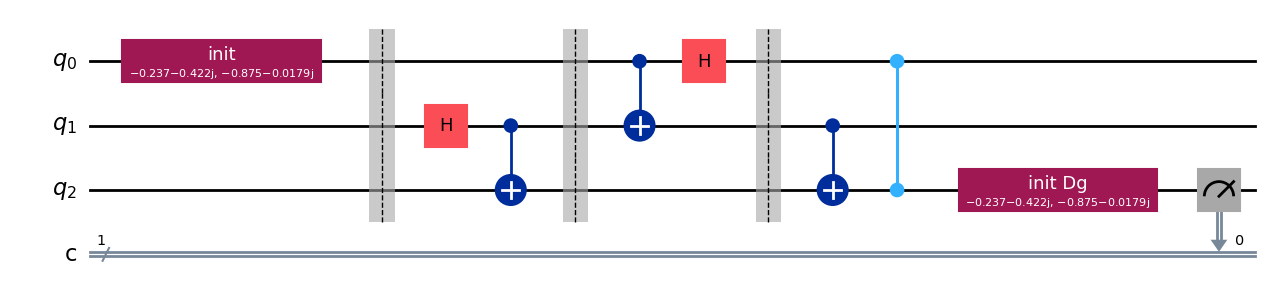

In [22]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw(output='mpl')

In [1]:
print("Usually jupyter kernel restars when trying to simulate the circuit due to high resources demand")
# qc.save_statevector()
# simulator = AerSimulator(method='statevector')
# qc = transpile(qc, simulator)
# results = simulator.run(qc).result()
# counts = results.get_counts(qc)
# plot_histogram(counts, title="Bob's decoded message")



Usually jupyter kernel restars when trying to simulate the circuit due to high resources demand
